# Signal to Binary Files (Train&Test)

In this notebook we read the Basic 4 dataset through Spark, and convert signals into a binary file.

In [3]:
import requests
import json
#!pip install ibmseti
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os

### Get file list

I have a list of simulated files stored in an OpenStack Object Storage container that is world-readable.

Download that file, split by lines and parallelize it into an RDD

In [ ]:
r = requests.get('https://xxxxx')

In [4]:
r = requests.get('https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_files/public_list_basic_v2_26may_2017.csv')

In [ ]:
filelist_txt = r.text

In [525]:
filelist_txt = r.text
fl_rdd = sc.parallelize(filelist_txt.split('\n')[1:-1], 20)
fl_rdd.count()

1000

#### Quick Inspection.

Take a look at the first row. Each line is CSV with 'uuid' and 'signal_classification'. We'll convert each line to JSON.  

In [527]:
def csvtojson(row):
    uuid, sigclass = row.split(',')
    return {'file_name':uuid+'.dat', 'uuid':uuid, 'signal_classification':sigclass}

fl_rdd2 = fl_rdd.map(csvtojson)
fl_rdd2.cache()

PythonRDD[141] at RDD at PythonRDD.scala:43

In [526]:
print fl_rdd2.first()
fl_rdd2.cache()

u'{"file_name": "00cb8c44-2289-445b-be14-14dfd7c6b2da.dat", "signal_classification": "narrowbanddrd", "uuid": "00cb8c44-2289-445b-be14-14dfd7c6b2da"}'

In [ ]:
base_url = 'https://xxxxx'

In [528]:
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'

Here is the different "signal_classifications" we have.

In [529]:
container = 'simsignals_basic_v2'
rdd_fname_lb = fl_rdd2.map(lambda row: (row['signal_classification'],row['file_name']))
classes = rdd_fname_lb.map(lambda row: row[0]).distinct().collect()
dictClass = dict(zip(classes, np.arange(4)))
dictClass

{u'narrowband': 2, u'narrowbanddrd': 1, u'noise': 3, u'squiggle': 0}

# Send request for data, and convert signals to spectogram

In [547]:
def get_spectrogram(fname,h,w,lengthRatio=1.0):
    
    r = requests.get('{}/{}/{}'.format(base_url, container, fname), timeout=4.0)
    if r.status_code != 200:
        print 'Failed retrieving {}'.format(fname)
        print r
        return None
    else:
        aca = ibmseti.compamp.SimCompamp(r.content)
        com_data = aca.complex_data()
        ratio = int(np.sqrt(len(com_data) *lengthRatio / (h*w)))
        if ratio == 0: 
            raise ValueError, "The selected lenght of signal is less than (Height x Width), select bigger ratio"
        elif ratio == 1:
            sig_data = com_data[:h*w].reshape(h,w)
            spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
            spec = np.log(spec) # Convert to float (0-255)
            image = 255*(spec/np.max(spec)) 
        elif ratio > 1: # resize using IPL image
            sig_data = com_data[:h*ratio*w*ratio].reshape(h*ratio,w*ratio)
            spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
            spec = np.log(spec) # Convert to float (0-255)
            image = 255*(spec/np.max(spec)) 
            img = Image.fromarray(image)  
            img = img.resize((int(w), int(h)), Image.ANTIALIAS)
            image = np.asarray(img) # float (0-255)
        
                
        # convert to grayscale: int(0-255)
        image = np.uint8(image)
        
        return image

h and w are the hight and width of the images, and lengthRatio is the length of signal in ratio.

In [551]:
h = 128 # The hight of output image (bins)
w = 256 # The witdh of output image
lengthRatio = 1.0  # the length-ration of signal to be read. The higher reatio, the better resolution. E.g. 0.5 means half of time sereis.
rdd_gray_spec = rdd_fname_lb.map(lambda row: (row[1], dictClass[row[0]], get_spectrogram(row[1],h,w,lengthRatio)))

In [552]:
rdd_gray_spec.cache()

PythonRDD[158] at RDD at PythonRDD.scala:43

### verify

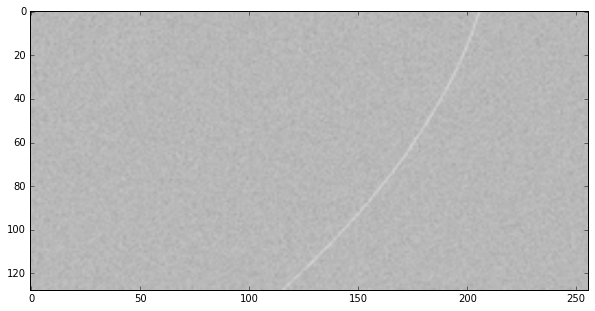

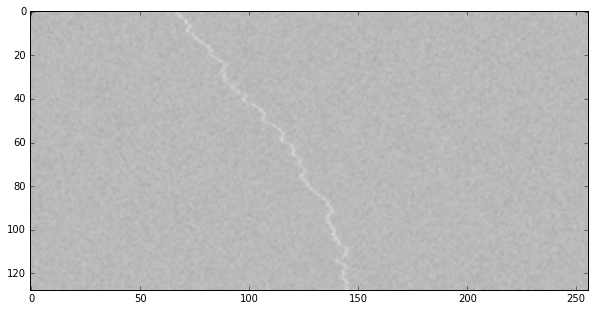

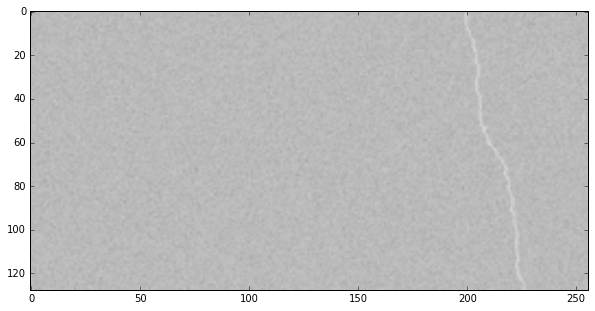

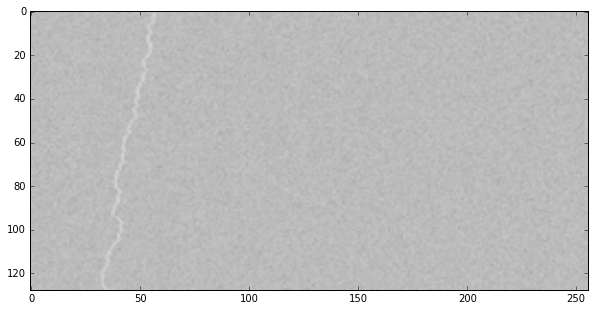

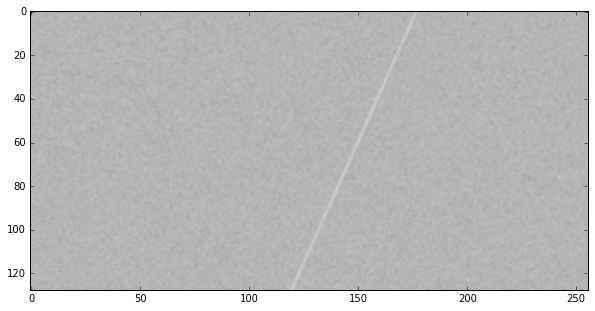

In [553]:
z=5
y= rdd_gray_spec.take(z)
for i in range(z):
    img = Image.fromarray(np.float32(y[i][2]))
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(img)

# Train/Test

In [554]:
test, train = rdd_gray_spec.randomSplit(weights=[0.3, 0.7], seed=1)

In [555]:
train_data = train.map(lambda row: row[2]).collect()
train_img_data = np.array(train_data)
train_lbl = train.map(lambda row: row[1]).collect()

In [556]:
test_data = test.map(lambda row: row[2]).collect()
test_img_data = np.array(test_data)
test_lbl = test.map(lambda row: row[1]).collect()

### Write to Binary file
This binary file is same as famouse __mnist__ dataset format to be read by different image processing algorithms, learning techniques and pattern recognition methods. 

There are 4 files:  

- train-images-idx3-ubyte: training set images 
- train-labels-idx1-ubyte: training set labels 
- test-images-idx3-ubyte:  test set images 
- test-labels-idx1-ubyte:  test set labels



In [557]:
from array import *
def wrtieToBinary(ds_directory, name , imgData , lblData,h,w):
    
    n = imgData.shape[0]
    imgData = imgData.reshape(-1,)
    
    data_image = array('B')
    data_label = array('B')
    
    data_image.extend(imgData)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6) 
    
    # header for label array
    data_label.extend(lblData)
    header = array('B')
    header.extend([0,0,8,1,0,0])
    header.append(int('0x'+hexval[2:][:2],16))
    header.append(int('0x'+hexval[2:][2:],16))
    data_label = header + data_label
    print ('Label header:' )
    print(header)
    # additional header for images array
    if max([w,h]) <= 255:
        header.extend([0,0,0,h,0,0,0,w])
    else:
        hex_h = "{0:#0{1}x}".format(h,6)
        header.extend([0,0])
        header.append(int('0x'+hex_h[2:][:2],16))
        header.append(int('0x'+hex_h[2:][2:],16))
        hex_w = "{0:#0{1}x}".format(w,6)
        header.extend([0,0])
        header.append(int('0x'+hex_w[2:][:2],16))
        header.append(int('0x'+hex_w[2:][2:],16))
        #raise ValueError('Image exceeds maximum size: 256x256 pixels');
    header[3] = 3 # Changing MSB for image data (0x00000803)
        
    if not os.path.exists(ds_directory):
        os.makedirs(ds_directory)
            
        
    print ('Image header:' )
    print(header)
    data_image = header + data_image

    output_file = open(ds_directory + name+'-images-idx3-ubyte', 'wb')
    data_image.tofile(output_file)
    output_file.close()

    output_file = open(ds_directory+ name+'-labels-idx1-ubyte', 'wb')
    data_label.tofile(output_file)
    output_file.close()
    
    # gzip resulting files


    os.system('gzip '+ ds_directory + name +'-images-idx3-ubyte '+ name +'-images-idx3-ubyte.gz')
    os.system('gzip '+ ds_directory + name +'-labels-idx1-ubyte ')


In [558]:
ds_directory = 'SETI/SETI_ds_128x256/'  # The dataset directory to write the binary files
os.system('rm '+ds_directory+'*')
print os.popen("ls -lrt "+ ds_directory).read()

total 0



In [559]:
wrtieToBinary(ds_directory, 'train' , train_img_data , train_lbl, h, w)

Label header:
array('B', [0, 0, 8, 1, 0, 0, 2, 182])
Image header:
array('B', [0, 0, 8, 3, 0, 0, 2, 182, 0, 0, 0, 128, 0, 0, 1, 0])


In [560]:
wrtieToBinary(ds_directory, 'test' , test_img_data , test_lbl, h, w)

Label header:
array('B', [0, 0, 8, 1, 0, 0, 1, 50])
Image header:
array('B', [0, 0, 8, 3, 0, 0, 1, 50, 0, 0, 0, 128, 0, 0, 1, 0])


### Verify the binary files
Lets read the binary file and plot an image

In [473]:
print os.popen("ls -lrt "+ ds_directory).read()

total 57264
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users 14035230 May 22 23:48 train-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users      306 May 22 23:48 train-labels-idx1-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users  6215859 May 22 23:48 test-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users      172 May 22 23:48 test-labels-idx1-ubyte.gz



In [474]:
import numpy as np
import gzip
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]

with open(ds_directory+'train-images-idx3-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        print(magic,num_images,rows,cols,)
        
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
# magic, num, rows, cols = struct.unpack(">IIII", bytestream.read(16))


(2051, 694, 128, 256)


F


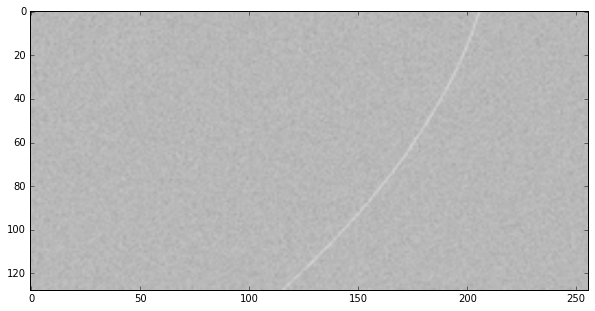

In [475]:
gray_y = data[0].reshape(h,w)
img = Image.fromarray(np.float32(gray_y))
print (img.mode)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [476]:
gray_y

array([[192, 188, 179, ..., 179, 183, 183],
       [181, 173, 177, ..., 182, 194, 185],
       [182, 189, 180, ..., 182, 190, 185],
       ..., 
       [184, 184, 186, ..., 189, 187, 176],
       [179, 181, 189, ..., 185, 185, 189],
       [193, 193, 186, ..., 186, 179, 183]], dtype=uint8)

### Verify the binary files by reader class
__SETI.py__ is a helper class, identical to mnist dataset reader, to easily read dataset, one-hot coding, and read images as batch.

In [561]:
!wget -q --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


In [562]:
SETIds = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
SETIds.train.num_examples

Extracting SETI/SETI_ds_128x256/train-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_128x256/train-labels-idx1-ubyte.gz
Extracting SETI/SETI_ds_128x256/test-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_128x256/test-labels-idx1-ubyte.gz


694

F


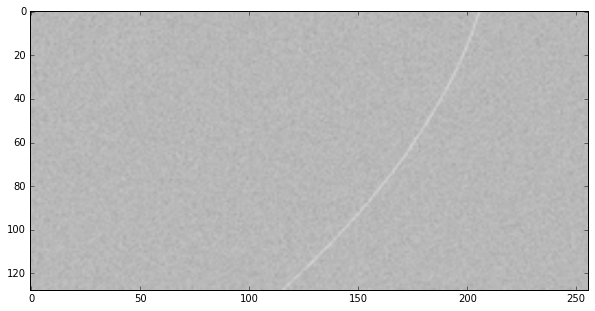

In [563]:
gray_y = SETIds.train.images[0].reshape(h,w)
img = Image.fromarray(gray_y*255)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

# Export files to object storage
You have to move the binary file to __object storage__ if you need to download the binary file.

In [481]:
print os.popen("ls -lrt "+ ds_directory).read()

total 59352
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users 14035230 May 22 23:48 train-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users      306 May 22 23:48 train-labels-idx1-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users  6215859 May 22 23:48 test-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users      172 May 22 23:48 test-labels-idx1-ubyte.gz



You need your credentials to move your files to object storage.
#### How to get the credentials for object storage?

Check this [link](https://github.com/ibm-cds-labs/seti_at_ibm#object-storage-credentials).

In [482]:
# 
credentials_1 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xx',
  'project_id':'xx',
  'region':'dallas',
  'user_id':'xx',
  'domain_id':'xx',
  'domain_name':'819515',
  'username':'xx',
  'password':"xx",
  'container':'x',
  'tenantId':'undefined',
  'filename':'SETI.py'
}

In [483]:
#!pip install --user --upgrade python-swiftclient

import swiftclient.client as swiftclient

conn = swiftclient.Connection(
    key=credentials_1['password'],
    authurl=credentials_1['auth_url']+"/v3",
    auth_version='3',
    os_options={
        "project_id": credentials_1['project_id'],
        "user_id": credentials_1['user_id'],
        "region_name": credentials_1['region']})

### Export the binary files as a single file to object storage

In [484]:
import gzip
local_file = 'SETI128x256.tar.gz'
os.system('tar -zcvf '+local_file+' '+ds_directory)
print ('Moving '+ local_file + '...')
with open(local_file, 'rb') as f:
    with gzip.GzipFile(fileobj=f) as bytestream:
        etag = conn.put_object(credentials_1['container'], local_file , f.read() )

Moving SETI128x256.tar.gz...


### Export the binary files as multiple files into object storage

In [ ]:
files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','test-images-idx3-ubyte.gz','test-labels-idx1-ubyte.gz']
for local_file in files:
    print ('Moving '+ local_file + '...')
    with open(ds_directory + local_file, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            etag = conn.put_object(credentials_1['container'], local_file , f.read() )